In [109]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from numpy.fft import rfft, rfftfreq, fft, ifft


In [110]:
def plot_sig_and_amplitude(sample_rate, time_sec, time, original_sig, title):
    fig, axs = plt.subplots(2, 1)
    
    rfft_sig = rfft(original_sig)
    magnitude_spectra = np.abs(rfft_sig)

    xf = rfftfreq(sample_rate*time_sec, 1 / sample_rate)
        
    axs[0].plot(time, original_sig)
    axs[0].grid()
    axs[0].set_xlabel('time (s)')
    axs[0].set_ylabel('Amplitude (V)')
    axs[0].set_title(title)
    
    axs[1].stem(xf, magnitude_spectra)
    axs[1].grid()
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Magnitude')
    
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [18, 15]

In [111]:
data = pd.read_csv('emotions.csv')
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.70,27.9,3.170,32.2,-368.0,15.90,36.4,7.08,28.8,-359.0,17.30,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.600,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.00,-185.00,-185.00,374.00,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.20,32.9,31.800,33.1,33.2,28.50,26.8,32.40,34.7,33.8,27.00,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.530,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.00,40.70,40.70,-19.00,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.40,20.0,79.800,31.0,-408.0,91.90,29.5,18.80,31.1,-335.0,32.20,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.000,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.00,-48.80,-48.80,159.00,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.90,27.7,15.700,30.7,-142.0,20.70,22.8,13.60,32.2,-135.0,21.20,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.830,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.90,-5.08,-5.08,-61.90,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.00,22.9,59.400,26.7,60.3,64.70,26.9,32.30,30.1,33.6,31.60,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.600,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.90,-7.25,-7.25,15.90,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,33.30,33.4,31.0,32.30,18.6,30.00,33.0,32.6,29.50,29.1,32.000,29.9,32.6,28.50,24.9,34.50,32.4,32.4,33.00,20.8,3.3500,0.461,-1.61000,2.880,-10.60,1.31,3.490,-1.540,3.860

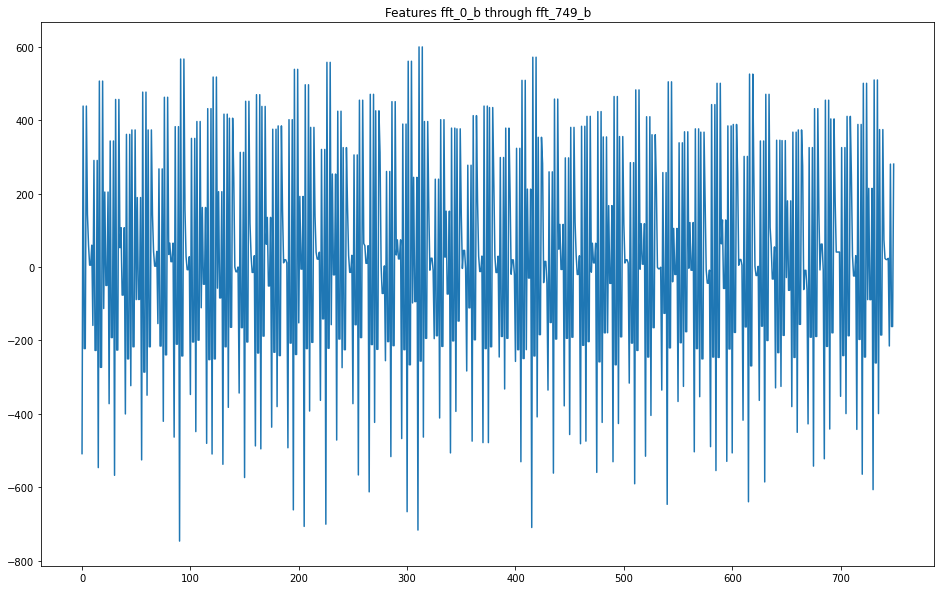

In [112]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

plt.figure(figsize=(16, 10))
plt.plot(range(len(sample)), sample)
plt.title("Features fft_0_b through fft_749_b")
plt.show()

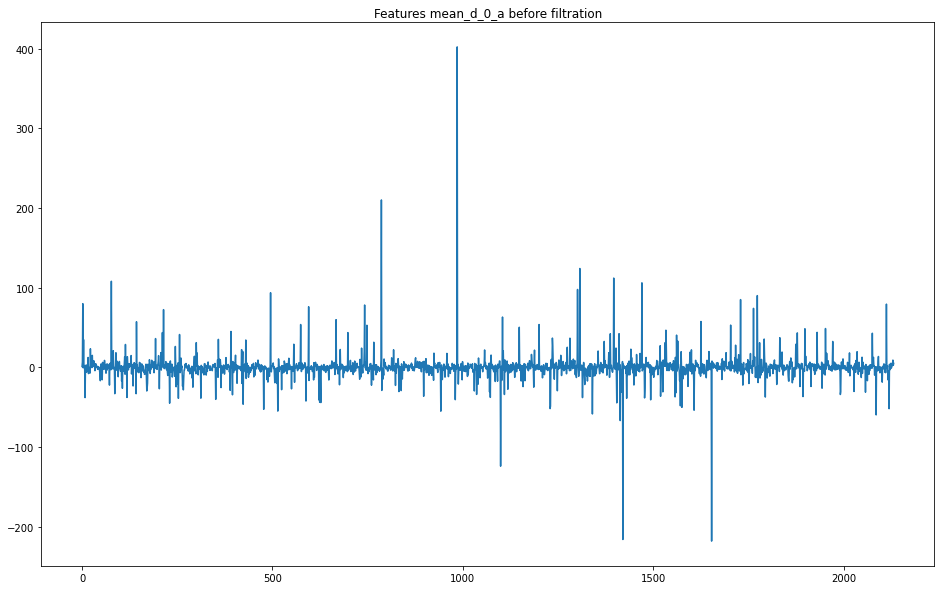

In [113]:
sample_rate = 128
sample = data['mean_d_0_a']

plt.figure(figsize=(16, 10))
plt.plot(range(len(sample)), sample)
plt.title("Features mean_d_0_a before filtration")
plt.show()


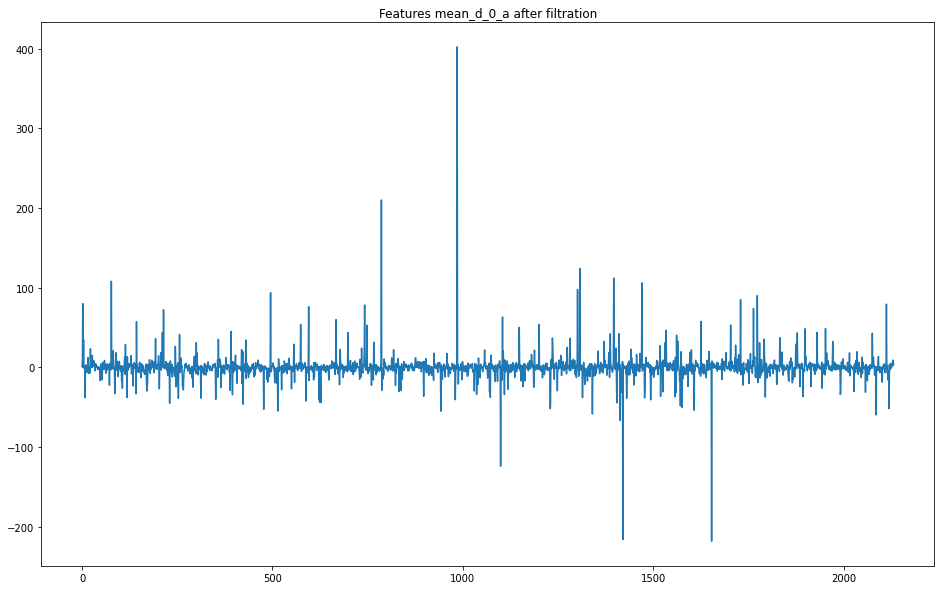

In [118]:
# sample = data['mean_d_0_a']

# plt.figure(figsize=(16, 10))
# plt.plot(range(len(sample)), sample)
# plt.title("Features mean_d_0_a after filtration")
# plt.show()

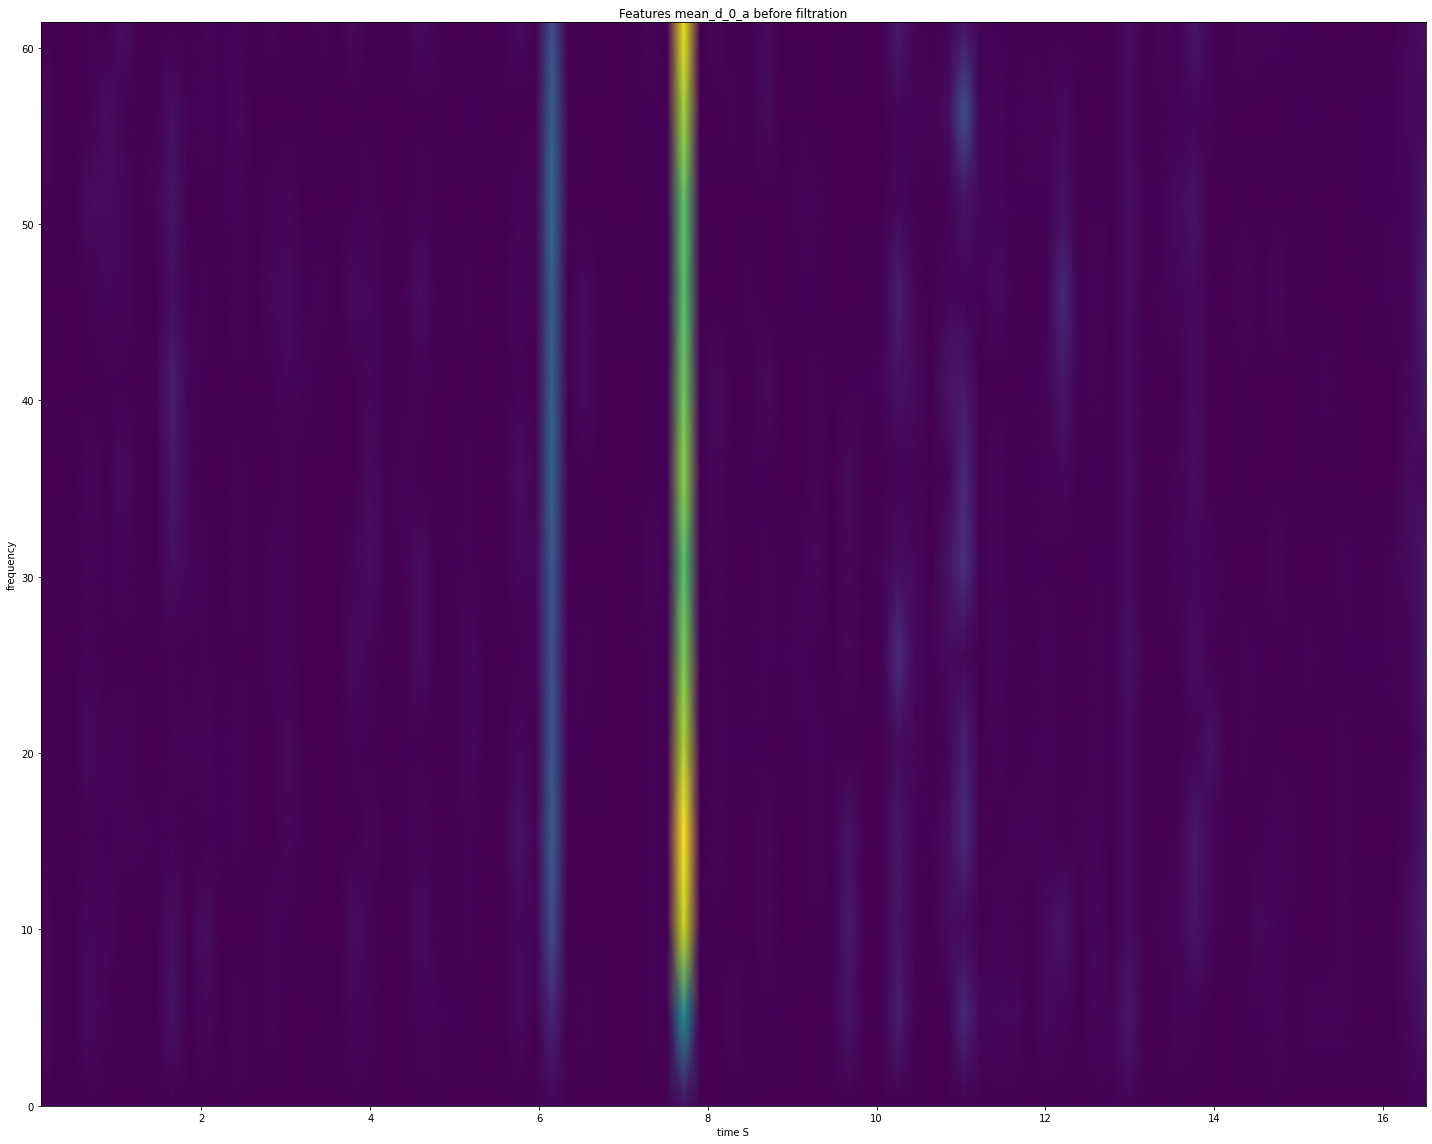

In [114]:


p = signal.windows.triang(int(sample_rate*0.2))

f, t, Sxx = signal.spectrogram(sample, sample_rate, p, noverlap=0, nperseg=len(p))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title(f'Features mean_d_0_a before filtration')
plt.xlabel('time S')
plt.ylabel('frequency')
    
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]

plt.show()

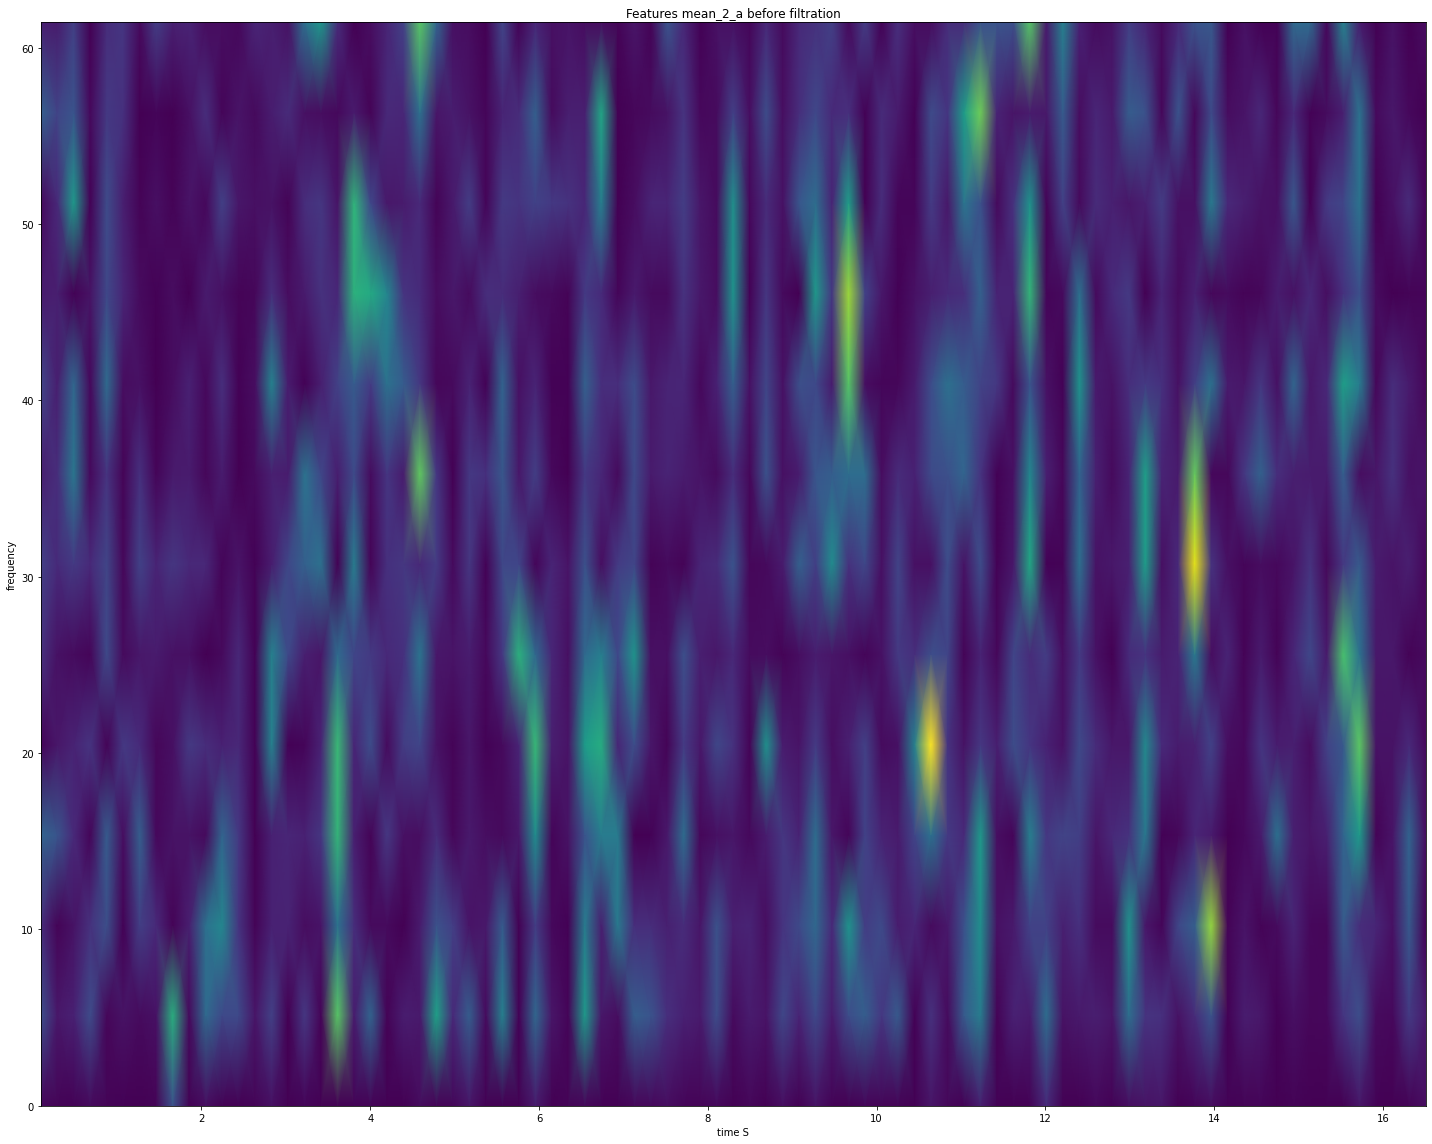

In [115]:
sample = data['mean_2_a']
f, t, Sxx = signal.spectrogram(sample, sample_rate, p, noverlap=0, nperseg=len(p))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title(f'Features mean_2_a before filtration')
plt.xlabel('time S')
plt.ylabel('frequency')
    
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]

plt.show()

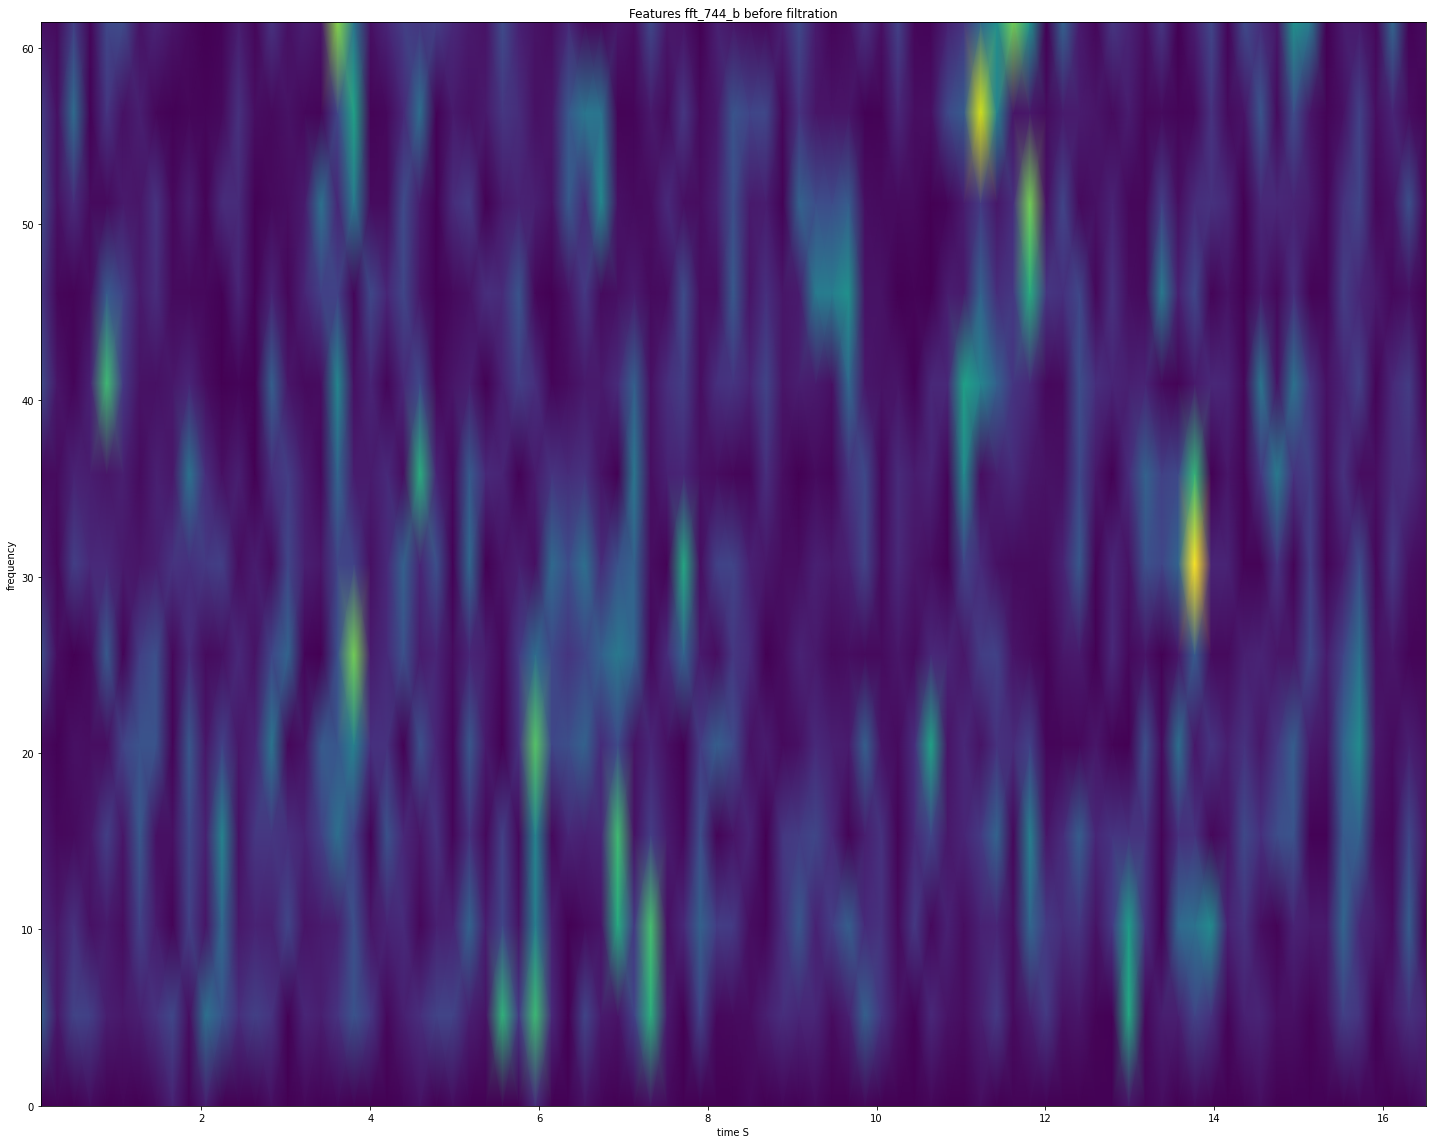

In [116]:
sample = data['fft_744_b']
f, t, Sxx = signal.spectrogram(sample, sample_rate, p, noverlap=0, nperseg=len(p))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title(f'Features fft_744_b before filtration')
plt.xlabel('time S')
plt.ylabel('frequency')
    
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 16]

plt.show()

In [117]:
from scipy import signal

N, Wn = signal.cheb1ord([12/64, 32/64],[6/64, 48/64], 4, 40)
b, a = signal.cheby1(N, 3, Wn, 'bandpass')
w, h = signal.freqz(b, a)
sos = signal.cheby1(N, 3, Wn, 'bandpass', output='sos')
# нижче відбувається фільтрація, але для фінального варіанту програма працює без неї
# for col in data.columns:
#   if type(data[col][0]) == str:
#     continue
#   data[col] = signal.sosfilt(sos, data[col])

In [119]:
data['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [120]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}


In [121]:
def preprocess_inputs(df):
    df = df.copy()
    
    df['label'] = df['label'].replace(label_mapping)
    
    y = df['label'].copy()
    X = df.drop('label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

In [122]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

##modelling

In [123]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2548)]            0         
                                                                 
 tf.expand_dims_5 (TFOpLambd  (None, 2548, 1)          0         
 a)                                                              
                                                                 
 gru_5 (GRU)                 (None, 2548, 256)         198912    
                                                                 
 flatten_5 (Flatten)         (None, 652288)            0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1956867   
                                                                 
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________

In [124]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/3
38/38 [==============================] - 259s 7s/step - loss: 43.0595 - accuracy: 0.7661 - val_loss: 8.9838 - val_accuracy: 0.9130
Epoch 2/3
38/38 [==============================] - 256s 7s/step - loss: 8.0730 - accuracy: 0.9103 - val_loss: 36.6609 - val_accuracy: 0.6756
Epoch 3/3
38/38 [==============================] - 235s 6s/step - loss: 11.6016 - accuracy: 0.8776 - val_loss: 14.5250 - val_accuracy: 0.8796


##results


In [125]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 90.938%


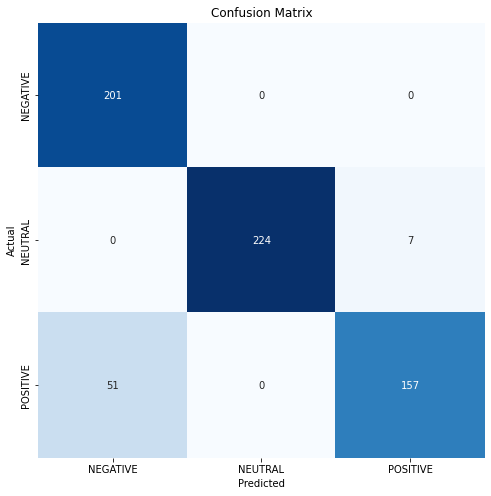

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.80      1.00      0.89       201
     NEUTRAL       1.00      0.97      0.98       231
    POSITIVE       0.96      0.75      0.84       208

    accuracy                           0.91       640
   macro avg       0.92      0.91      0.91       640
weighted avg       0.92      0.91      0.91       640



In [126]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)